In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.expand_frame_repr', False)

In [2]:
# Import necessary libraries and packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Set floating point precision option for pandas
pd.set_option('display.float_format', lambda x: '%.4f' % x)

# Import seaborn library and set context and style
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')

# Import warnings and set filter to ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Import time library
from time import time

# Import matplotlib ticker and scipy stats
import matplotlib.ticker as tkr
from scipy import stats

# Import statistical tools for time series analysis
from statsmodels.tsa.stattools import adfuller

# Import preprocessing from sklearn
from sklearn import preprocessing

# Import partial autocorrelation function from statsmodels
from statsmodels.tsa.stattools import pacf

# Enable inline plotting in Jupyter Notebook
%matplotlib inline

# Import math library
import math

# Import necessary functions from keras
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *

# Import MinMaxScaler from sklearn
from sklearn.preprocessing import MinMaxScaler

# Import mean squared error and mean absolute error from sklearn
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# Import early stopping from keras callbacks
from keras.callbacks import EarlyStopping

In [3]:
df = pd.read_csv('household_power_consumption.csv', index_col=0)

In [4]:
df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
index,,,,,,,,,
0,1/1/07,0:00:00,2.58,0.136,241.97,10.6,0,0,0.0000
1,1/1/07,0:01:00,2.552,0.1,241.75,10.4,0,0,0.0000
2,1/1/07,0:02:00,2.55,0.1,241.64,10.4,0,0,0.0000
3,1/1/07,0:03:00,2.55,0.1,241.71,10.4,0,0,0.0000
4,1/1/07,0:04:00,2.554,0.1,241.98,10.4,0,0,0.0000


In [5]:
df.tail()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
index,,,,,,,,,
260635,30/6/2007,23:55:00,2.88,0.36,239.01,12,0,0,18.0000
260636,30/6/2007,23:56:00,2.892,0.358,238.86,12.2,0,0,17.0000
260637,30/6/2007,23:57:00,2.882,0.28,239.05,12,0,0,18.0000
260638,30/6/2007,23:58:00,2.66,0.29,238.98,11.2,0,0,18.0000
260639,30/6/2007,23:59:00,2.548,0.354,239.25,10.6,0,1,17.0000


In [6]:
# # new feature about power
# df['power'] = df['Voltage'] * df['Global_intensity']/1000
# df['total_power'] = df['Global_active_power'] + df['Global_reactive_power']+df['Sub_metering_1']+df['Sub_metering_2']+df['Sub_metering_3']
# df['Global_active_power_hour'] = df['Global_active_power'] * 1000 / 60
# (df['Global_active_power_hour']<df['Sub_metering_1']+df['Sub_metering_2']+df['Sub_metering_3']).sum()
# print((df['power']-df['total_power']).max(), (df['power']-df['total_power']).min())

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 260640 entries, 0 to 260639
Data columns (total 9 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Date                   260640 non-null  object 
 1   Time                   260640 non-null  object 
 2   Global_active_power    260640 non-null  object 
 3   Global_reactive_power  260640 non-null  object 
 4   Voltage                260640 non-null  object 
 5   Global_intensity       260640 non-null  object 
 6   Sub_metering_1         260640 non-null  object 
 7   Sub_metering_2         260640 non-null  object 
 8   Sub_metering_3         256869 non-null  float64
dtypes: float64(1), object(8)
memory usage: 19.9+ MB


issue 1: numeric data shown as object type, since nan data are shown as '?'

In [8]:
df.replace('?', np.NaN, inplace=True)
# unknown or nan data\
(df=='?').sum(axis = 0)

Date                     0
Time                     0
Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

In [9]:
# change object type to numeric 
cols = ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2']
for col in cols:
    df[col] = pd.to_numeric(df[col]) 

issue 2: date are in two different formats

In [10]:
def convert_year(s):
    if s[-4:] == '2007':
        s = s[:-4]+'07'
    return s
convert_year('13/1/2007')

'13/1/07'

In [11]:
df['Date']=df['Date'].apply(lambda x: convert_year(x))
df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%y %H:%M:%S')

In [12]:
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%y')

In [13]:
df.describe()

,Date,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,datetime
count,260640,256869.0000,256869.0000,256869.0000,256869.0000,256869.0000,256869.0000,256869.0000,260640
mean,2007-04-01 00:00:00,1.1649,0.1237,239.2090,4.9748,1.3325,1.6706,5.8318,2007-04-01 11:59:29.999999232
min,2007-01-01 00:00:00,0.0820,0.0000,223.4900,0.4000,0.0000,0.0000,0.0000,2007-01-01 00:00:00
25%,2007-02-15 00:00:00,0.2960,0.0000,236.6500,1.4000,0.0000,0.0000,0.0000,2007-02-15 05:59:45
50%,2007-04-01 00:00:00,0.5640,0.1040,239.6100,2.6000,0.0000,0.0000,0.0000,2007-04-01 11:59:30
75%,2007-05-16 00:00:00,1.6060,0.1940,241.8100,6.8000,0.0000,1.0000,17.0000,2007-05-16 17:59:15
max,2007-06-30 00:00:00,10.6700,1.1480,250.8900,46.4000,78.0000,78.0000,20.0000,2007-06-30 23:59:00
std,NaN,1.1818,0.1119,3.5928,4.9995,6.7050,6.6314,8.1867,NaN


In [14]:
df[df.Sub_metering_1==78]

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,datetime
index,,,,,,,,,,
208597,2007-05-25,20:37:00,6.9800,0.4340,230.9600,30.2000,78.0000,2.0000,17.0000,2007-05-25 20:37:00
208599,2007-05-25,20:39:00,6.9220,0.3180,231.6900,29.8000,78.0000,1.0000,17.0000,2007-05-25 20:39:00
208604,2007-05-25,20:44:00,6.8660,0.3200,230.6600,29.8000,78.0000,1.0000,16.0000,2007-05-25 20:44:00


In [15]:
df.sort_values('datetime', inplace=True)

In [16]:
# Create new columns for year, quarter, month, and day
# df['year'] = df['datetime'].apply(lambda x: x.year)
# df['quarter'] = df['datetime'].apply(lambda x: x.quarter)
df['month'] = df['datetime'].apply(lambda x: x.month)
df['week'] = df['datetime'].apply(lambda x: x.week)
df['dayofweek'] = df['datetime'].apply(lambda x: x.dayofweek)
df['day'] = df['datetime'].apply(lambda x: x.day)
df['hour'] = df['datetime'].apply(lambda x: x.hour)

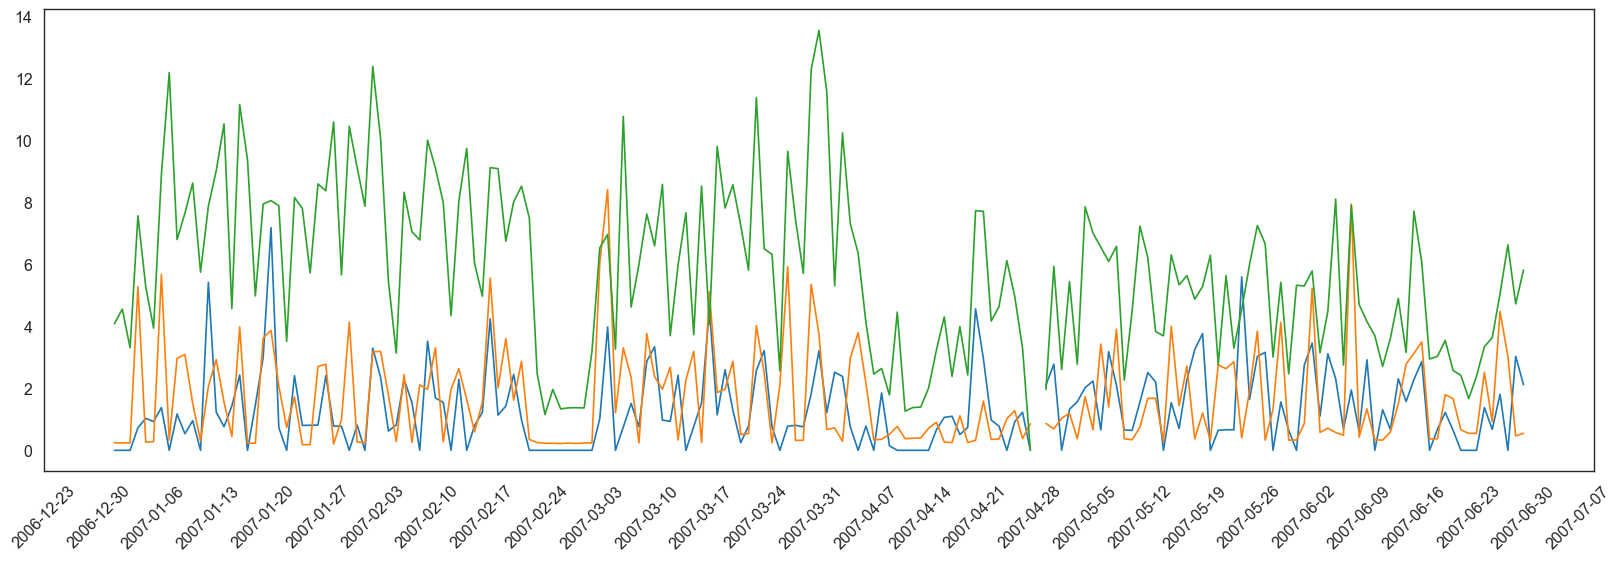

In [17]:
fig, ax = plt.subplots(figsize=(20,6))
plt.plot(df.groupby('Date')[['Sub_metering_1','Sub_metering_2','Sub_metering_3']].mean().sort_index())
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(start, end, 7))
plt.xticks(rotation=45)
plt.show()

no missing dates

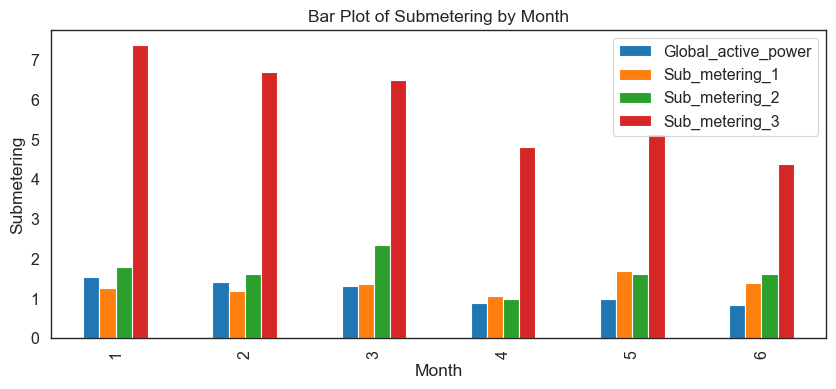

In [18]:
fig, ax = plt.subplots(figsize=(10, 4))
monthly = df.groupby('month')[['Global_active_power', 'Sub_metering_1','Sub_metering_2','Sub_metering_3']].mean()
monthly.plot(kind='bar', ax=ax)
plt.xlabel('Month')
plt.ylabel('Submetering')
plt.title('Bar Plot of Submetering by Month')
plt.show()


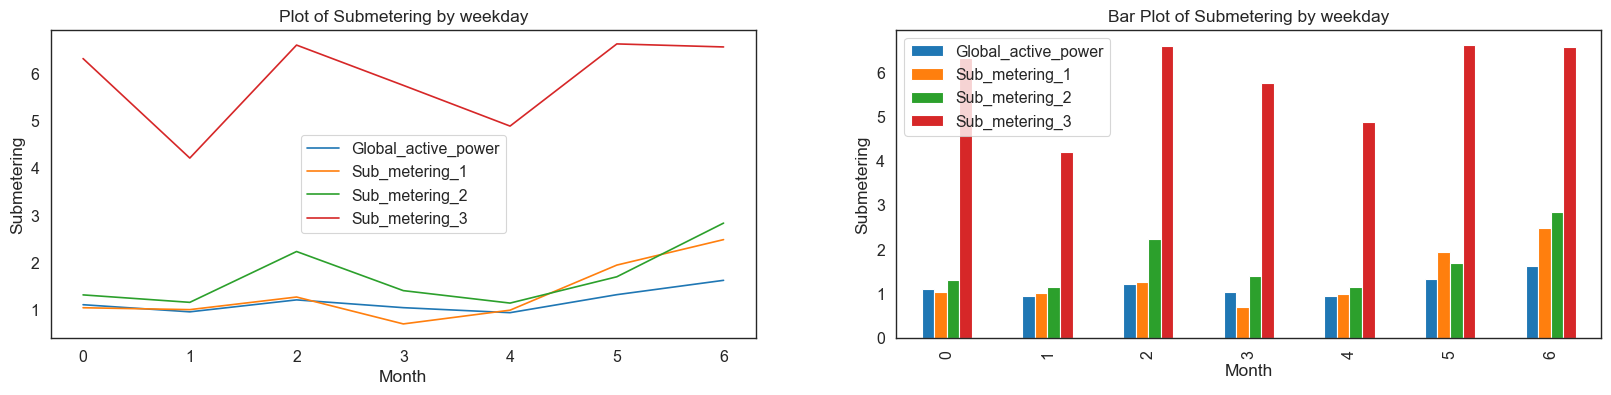

In [19]:
fig, ax = plt.subplots(ncols=2, figsize=(20, 4))
weekly = df.groupby('dayofweek')[['Global_active_power', 'Sub_metering_1','Sub_metering_2','Sub_metering_3']].mean()
weekly.plot(ax=ax[0])
ax[0].set_xlabel('Month')
ax[0].set_ylabel('Submetering')
ax[0].set_title('Plot of Submetering by weekday')
weekly.plot(kind='bar', ax=ax[1])
ax[1].set_xlabel('Month')
ax[1].set_ylabel('Submetering')
ax[1].set_title('Bar Plot of Submetering by weekday')
plt.show()

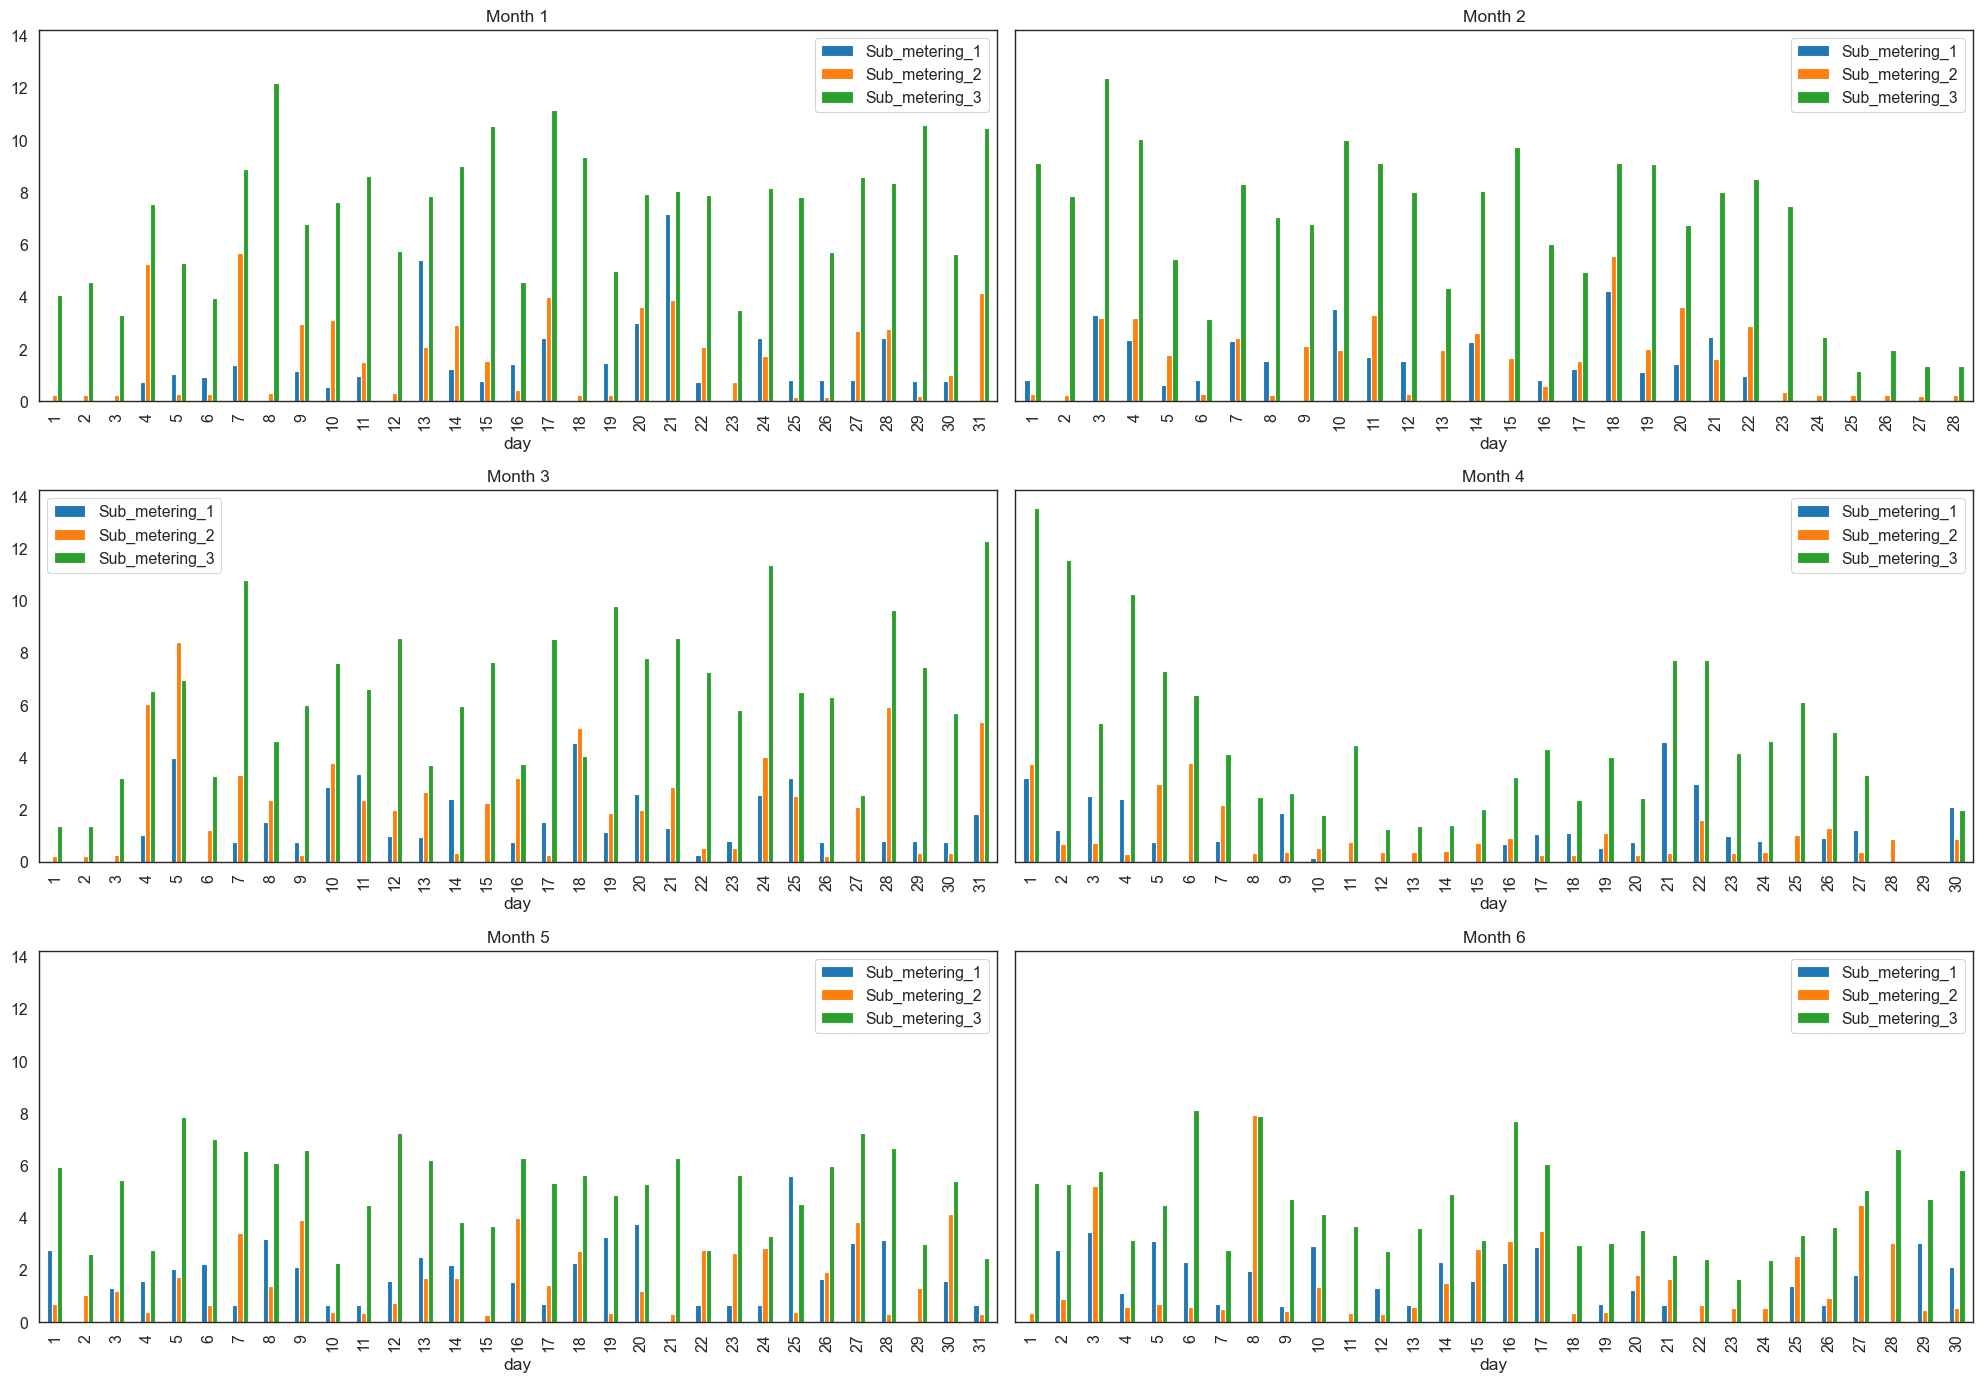

In [20]:
fig, ax = plt.subplots(ncols=2, nrows=3, figsize=(20, 14), sharey=True)
for i in range(6):
    monthly = df[df.month==i+1].groupby('day')[['Sub_metering_1','Sub_metering_2','Sub_metering_3']].mean()
    monthly.plot(kind='bar', ax=ax[i//2][i%2])
    # ax.xlabel('Month')
    # ax.ylabel('Submetering')
    # ax.title('Bar Plot of Submetering by Month')
    ax[i//2][i%2].set_title('Month {}'.format(i+1))
plt.tight_layout()
plt.show()


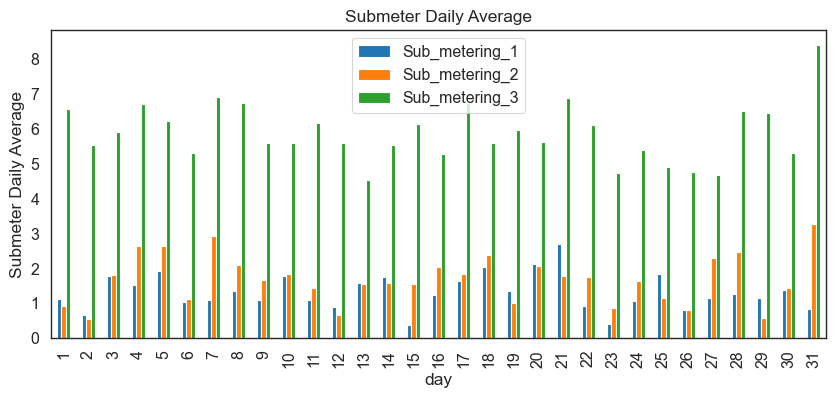

In [21]:
# Submeter hourly average

submeter_hourly_avg = df.groupby('day')[['Sub_metering_1','Sub_metering_2','Sub_metering_3']].mean()
submeter_hourly_avg.plot(kind='bar', figsize=(10, 4))
plt.xlabel('day')
plt.ylabel('Submeter Daily Average')
plt.title('Submeter Daily Average')
plt.show()

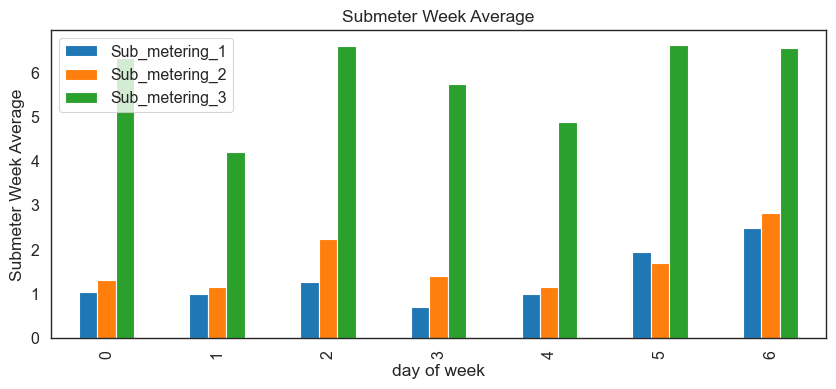

In [22]:
# Submeter hourly average

submeter_hourly_avg = df.groupby('dayofweek')[['Sub_metering_1','Sub_metering_2','Sub_metering_3']].mean()
submeter_hourly_avg.plot(kind='bar', figsize=(10, 4))
plt.xlabel('day of week')
plt.ylabel('Submeter Week Average')
plt.title('Submeter Week Average')
plt.show()

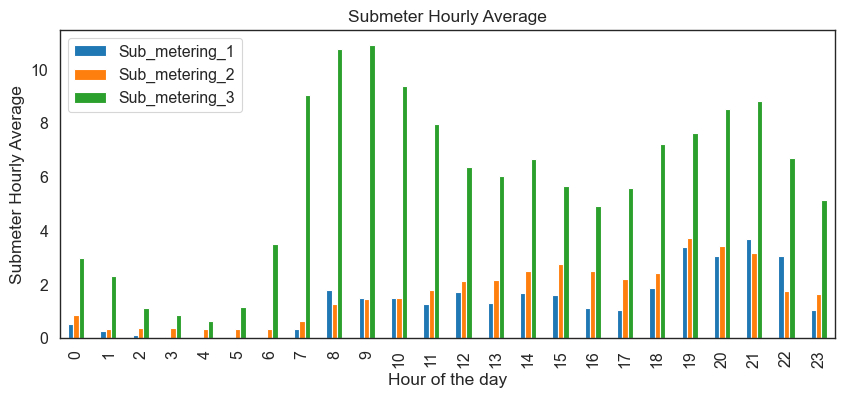

In [23]:
# Submeter hourly average

submeter_hourly_avg = df.groupby('hour')[['Sub_metering_1','Sub_metering_2','Sub_metering_3']].mean()
submeter_hourly_avg.plot(kind='bar', figsize=(10, 4))
plt.xlabel('Hour of the day')
plt.ylabel('Submeter Hourly Average')
plt.title('Submeter Hourly Average')
plt.show()

In [24]:
df.columns

Index(['Date', 'Time', 'Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3', 'datetime', 'month', 'week', 'dayofweek', 'day', 'hour'], dtype='object')

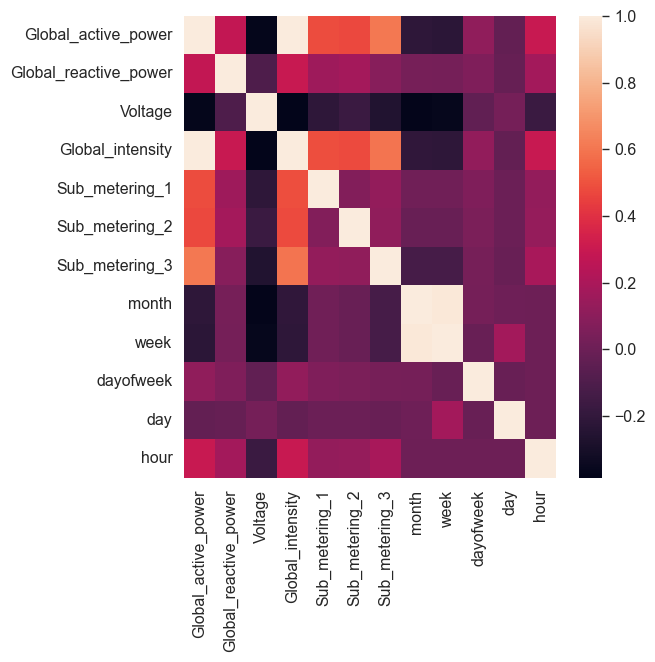

In [25]:
cols = ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3', 'month', 'week', 'dayofweek', 'day', 'hour']
plt.figure(figsize=(6,6))
sns.heatmap(df[cols].corr())
plt.show()

# Time series
Goal: predict total active power or forecast total active power for later

Demonstrate some seasonality

### check normality

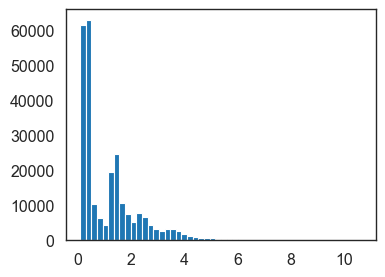

In [26]:
plt.figure(figsize=(4,3))
plt.hist(df.Global_active_power, bins=50)
plt.show()

In [27]:
from scipy.stats import shapiro
# test for normality
# Perform Shapiro-Wilk test for normality

stat, p = shapiro(df['Global_active_power'].dropna())

# Print the test statistic and p-value
print("Test Statistic:", stat)
print("p-value:", p)
# reject null hypothesis, not normal

Test Statistic: 0.7956900989702604
p-value: 2.8295223331183687e-154


In [28]:
# kurtosis
from scipy.stats import kurtosis, skew
print('kurtosis:', kurtosis(df['Global_active_power'].dropna()))
print('skewness:', df['Global_active_power'].dropna().skew())

kurtosis: 3.3705802667700926
skewness: 1.6979940452818296


Normal distribution has 0 kurtosis, 0 skew. This distribution have heavy tails and assymetric. 

If the skewness is between -0.5 and 0.5, the data is considered fairly symmetrical.

If the skewness falls between -1 and -0.5 or between 0.5 and 1, the data is considered moderately skewed.

If the skewness is less than -1 or greater than 1, the data is considered highly skewed. 

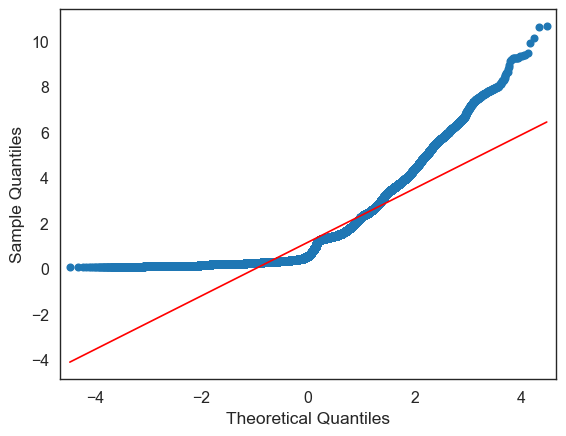

In [29]:
# Q-Q plot
from statsmodels.graphics.gofplots import qqplot
qqplot(df['Global_active_power'].dropna(), line='s')

# plt.plot([0, max(df['Global_active_power'])], [0, max(df['Global_active_power'])], color='purple', linestyle='--')
plt.show()

posx and posy should be finite values
posx and posy should be finite values


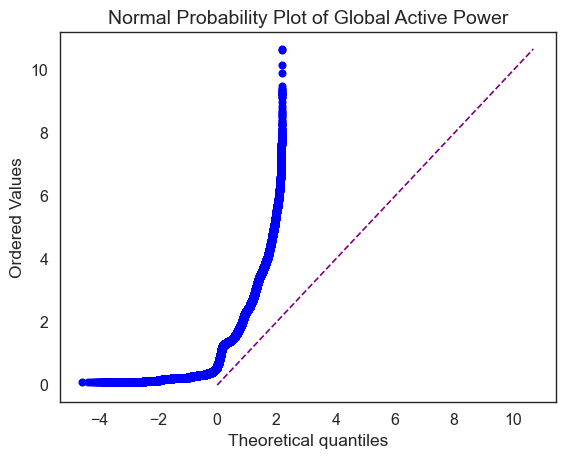

In [30]:
# Create the normal probability plot using stats.probplot
from scipy import stats
stats.probplot(df['Global_active_power'], plot=plt, fit=True, rvalue=True)
# Add a line to the plot
plt.plot([0, max(df['Global_active_power'])], [0, max(df['Global_active_power'])], color='purple', linestyle='--')
plt.title('Normal Probability Plot of Global Active Power', fontsize=14)
plt.show()

### Seasonality

In [31]:
df.set_index('datetime', inplace=True)

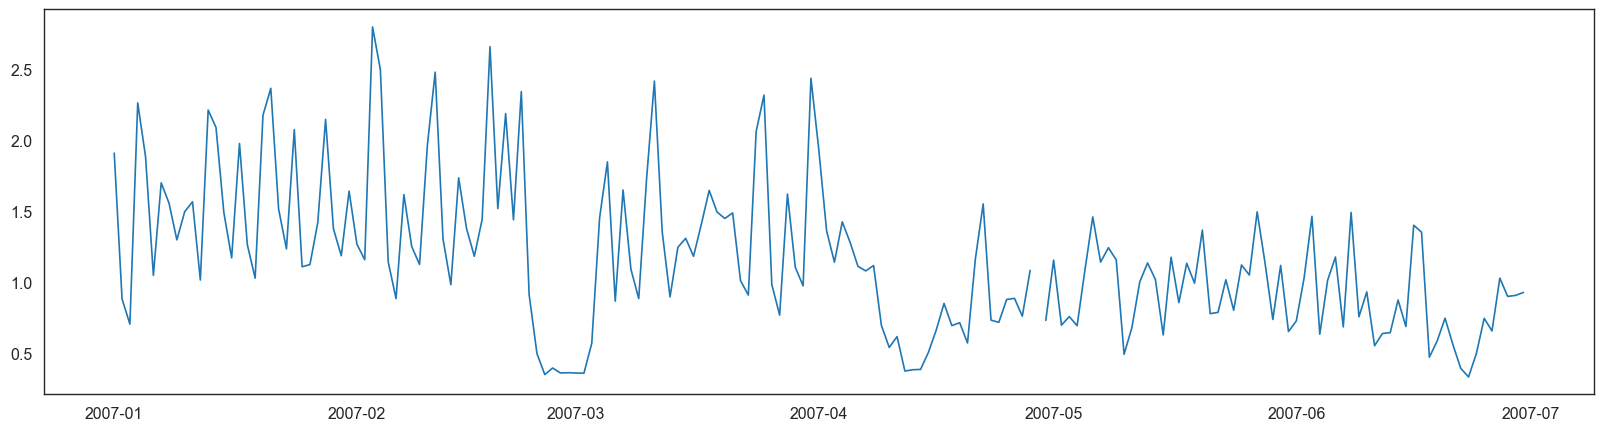

In [32]:
plt.figure(figsize=(20,5))
plt.plot(df['Global_active_power'].resample('D').mean())
plt.show()

### Stationarity

### Time series Analysis

In [33]:
y = df[['Global_active_power']].dropna()
y

,Global_active_power
datetime,
2007-01-01 00:00:00,2.5800
2007-01-01 00:01:00,2.5520
2007-01-01 00:02:00,2.5500
2007-01-01 00:03:00,2.5500
2007-01-01 00:04:00,2.5540
...,...
2007-06-30 23:55:00,2.8800
2007-06-30 23:56:00,2.8920
2007-06-30 23:57:00,2.8820


In [34]:
roll_mean = y.rolling(window=7, center=False).mean()
roll_std = y.rolling(window=7, center=False).std()

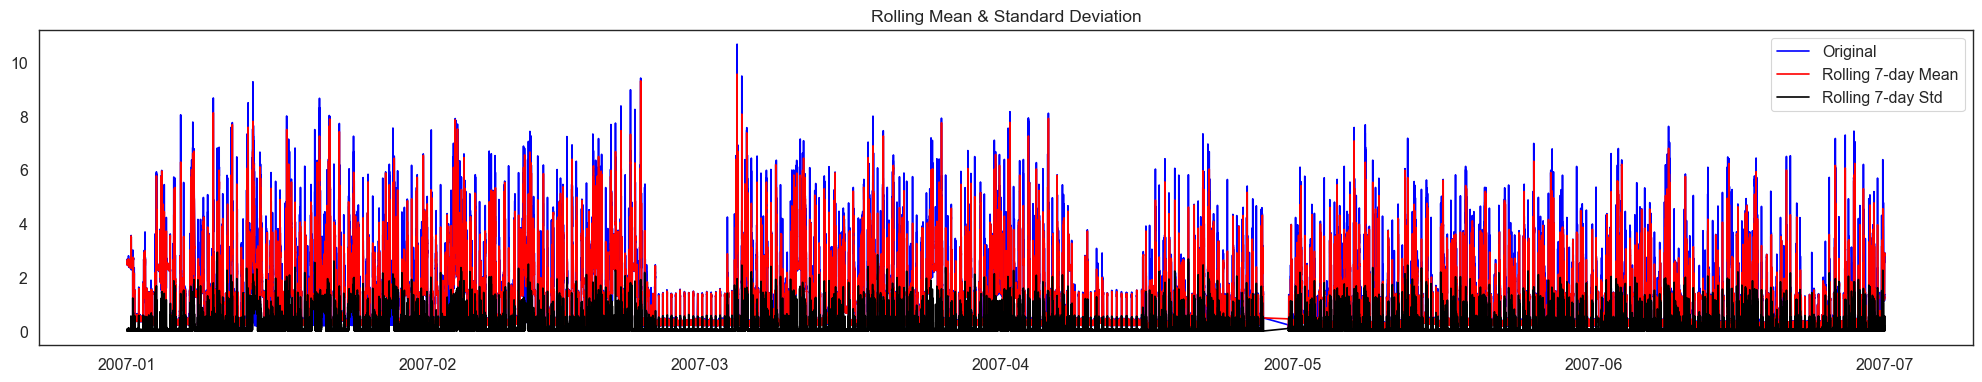

In [35]:
fig, ax = plt.subplots(figsize=(20,4))
ax.plot(y, color='blue',label='Original')
ax.plot(roll_mean, color='red', label='Rolling 7-day Mean')
ax.plot(roll_std, color='black', label='Rolling 7-day Std')
ax.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
fig.tight_layout()

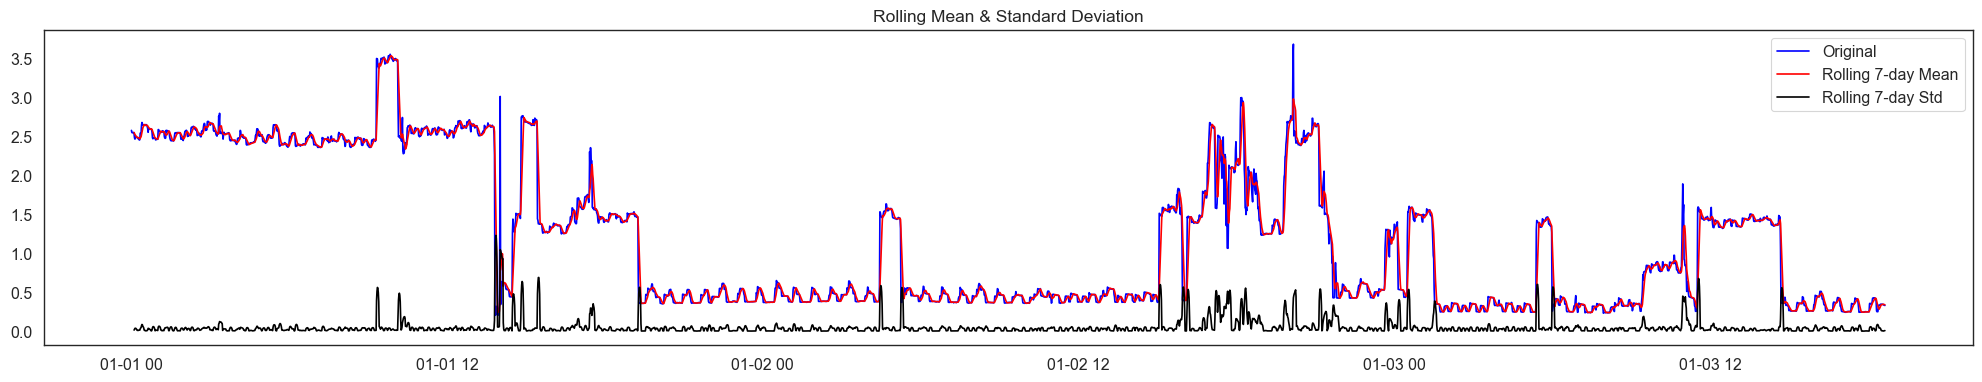

In [36]:
fig, ax = plt.subplots(figsize=(20,4))
ax.plot(y[:4000], color='blue',label='Original')
ax.plot(roll_mean[:4000], color='red', label='Rolling 7-day Mean')
ax.plot(roll_std[:4000], color='black', label='Rolling 7-day Std')
ax.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
fig.tight_layout()

As you can see in the above figure standard deviation value is lower which means Data is closely clustered around mean

Low Standard Deviation — Data is closely clustered around mean

High Standard Deviation — Data is scattered over a range of values

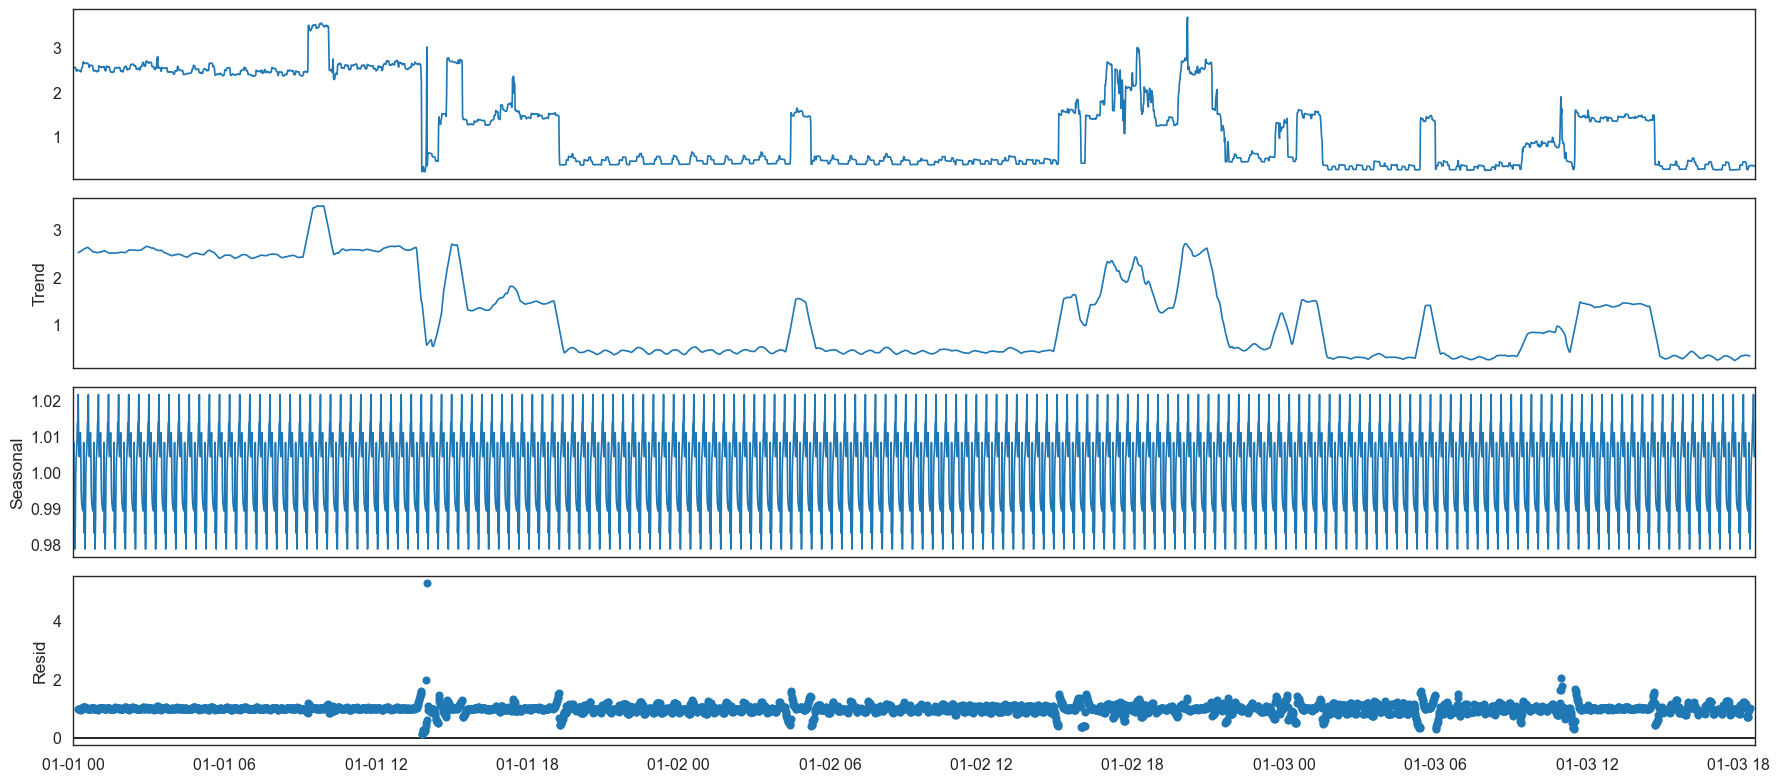

In [37]:
import statsmodels.api as sm
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y[:4000], model='multiplicative', period=24)
fig = decomposition.plot()
plt.show()

From previous visualizations and understanding, I’m choosing the ‘Multiplicative’ model as data have some seasonal component. 

(I would have used the additive model if the data would have had an upward or downward trend)

We see the trend of  and have cyclic seasonality.

In [38]:
from statsmodels.tsa.stattools import adfuller
def adf_test(df):
    dftest = adfuller(df, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
adf_test(y)

Test Statistic                   -25.7710
p-value                            0.0000
#Lags Used                        85.0000
Number of Observations Used   256783.0000
Critical Value (1%)               -3.4304
Critical Value (5%)               -2.8616
Critical Value (10%)              -2.5668
dtype: float64


### Machine Learning

In [39]:
df.columns

Index(['Date', 'Time', 'Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3', 'month', 'week', 'dayofweek', 'day', 'hour'], dtype='object')

In [40]:
len(df)/4*3

195480.0

In [41]:
df.iloc[:195480,:]

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,month,week,dayofweek,day,hour
datetime,,,,,,,,,,,,,,
2007-01-01 00:00:00,2007-01-01,0:00:00,2.5800,0.1360,241.9700,10.6000,0.0000,0.0000,0.0000,1,1,0,1,0
2007-01-01 00:01:00,2007-01-01,0:01:00,2.5520,0.1000,241.7500,10.4000,0.0000,0.0000,0.0000,1,1,0,1,0
2007-01-01 00:02:00,2007-01-01,0:02:00,2.5500,0.1000,241.6400,10.4000,0.0000,0.0000,0.0000,1,1,0,1,0
2007-01-01 00:03:00,2007-01-01,0:03:00,2.5500,0.1000,241.7100,10.4000,0.0000,0.0000,0.0000,1,1,0,1,0
2007-01-01 00:04:00,2007-01-01,0:04:00,2.5540,0.1000,241.9800,10.4000,0.0000,0.0000,0.0000,1,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2007-05-16 17:55:00,2007-05-16,17:55:00,0.3520,0.1220,235.5200,1.6000,0.0000,0.0000,0.0000,5,20,2,16,17
2007-05-16 17:56:00,2007-05-16,17:56:00,0.4060,0.2020,237.4800,1.8000,0.0000,0.0000,0.0000,5,20,2,16,17
2007-05-16 17:57:00,2007-05-16,17:57:00,0.4000,0.1980,236.5200,1.8000,0.0000,0.0000,0.0000,5,20,2,16,17


In [42]:
# train-test split
# from sklearn.model_selection import train_test_split
# multivariante
df.dropna(inplace=True)
X_cols = ['Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3', 'month', 'week', 'dayofweek', 'day', 'hour']
X_train, y_train, X_test, y_test = df.iloc[:195480,:][X_cols], df.iloc[:195480,:]['Global_active_power'],df.iloc[195480:,:][X_cols], df.iloc[195480:,:]['Global_active_power']

In [43]:
# univariate
train = df.reset_index().iloc[:195480,:]['Global_active_power']
test = df.reset_index().iloc[195480:,:]['Global_active_power']

In [44]:
# baseline model
# linear regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

linreg = LinearRegression()
linreg.fit(X_train, y_train)
pred = linreg.predict(X_test)
print('rsme:', np.sqrt(mean_squared_error(pred,y_test))) 

rsme: 0.04459507323428889


In [45]:
linreg.coef_

array([-0.15105945,  0.00476797,  0.2374228 , -0.00058848, -0.00067257,
        0.00202708,  0.0132061 , -0.00321259, -0.00062039,  0.00032713,
        0.00030552])

In [46]:
# holt winter exponential smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
es = ExponentialSmoothing(train, trend = 'add', seasonal='add', seasonal_periods=24).fit()
es.summary()

Dep. Variable:,Global_active_power,No. Observations:,195480
Model:,ExponentialSmoothing,SSE,19973.757
Optimized:,True,AIC,-445841.465
Trend:,Additive,BIC,-445556.335
Seasonal:,Additive,AICC,-445841.455
Seasonal Periods:,24,Date:,"Fri, 16 Feb 2024"
Box-Cox:,False,Time:,18:48:00
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.9950832,alpha,True
smoothing_trend,0.0001031,beta,True


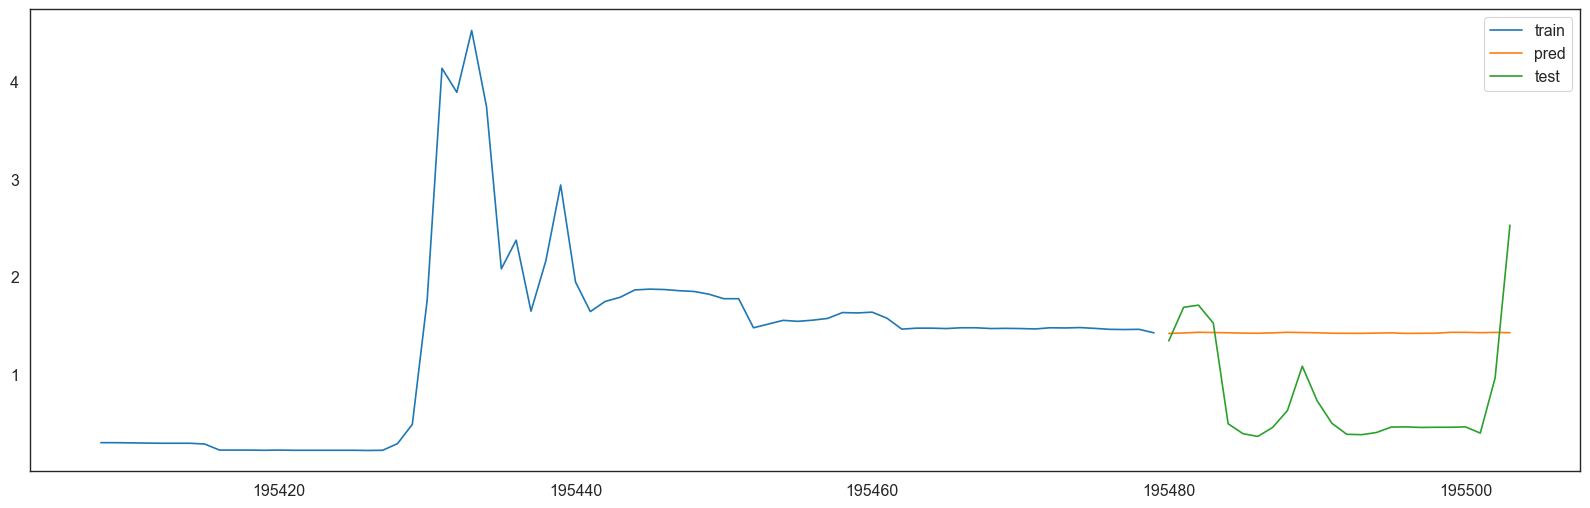

In [47]:
es_pred = es.forecast(24)
fig, ax = plt.subplots(1,1, figsize=(20,6))
ax.plot(train.tail(72), label='train')
ax.plot(es_pred, label='pred')
ax.plot(test[:24], label='test')
ax.legend()
plt.show()

In [48]:
print('rsme:', np.sqrt(mean_squared_error(es_pred,test[:24]))) 

rsme: 0.8548638878332373


# Time series

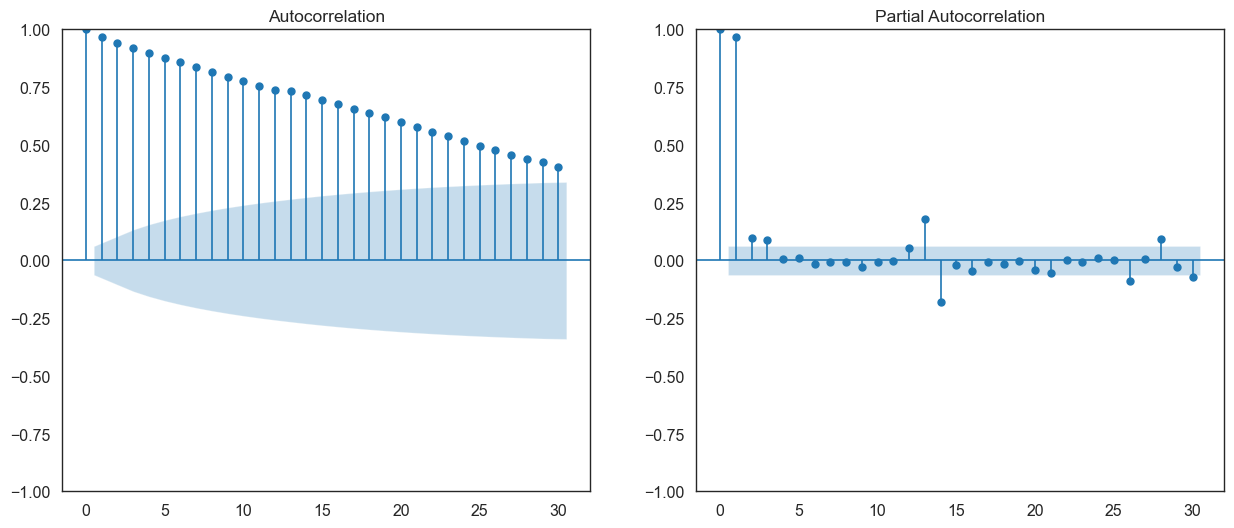

In [49]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(1,2,figsize=(15,6))
plot_acf(train[:1000],ax=ax[0])
plot_pacf(train[:1000],ax=ax[1])
plt.show()

In [50]:
train

0        2.5800
1        2.5520
2        2.5500
3        2.5500
4        2.5540
          ...  
195475   1.4700
195476   1.4600
195477   1.4580
195478   1.4600
195479   1.4240
Name: Global_active_power, Length: 195480, dtype: float64

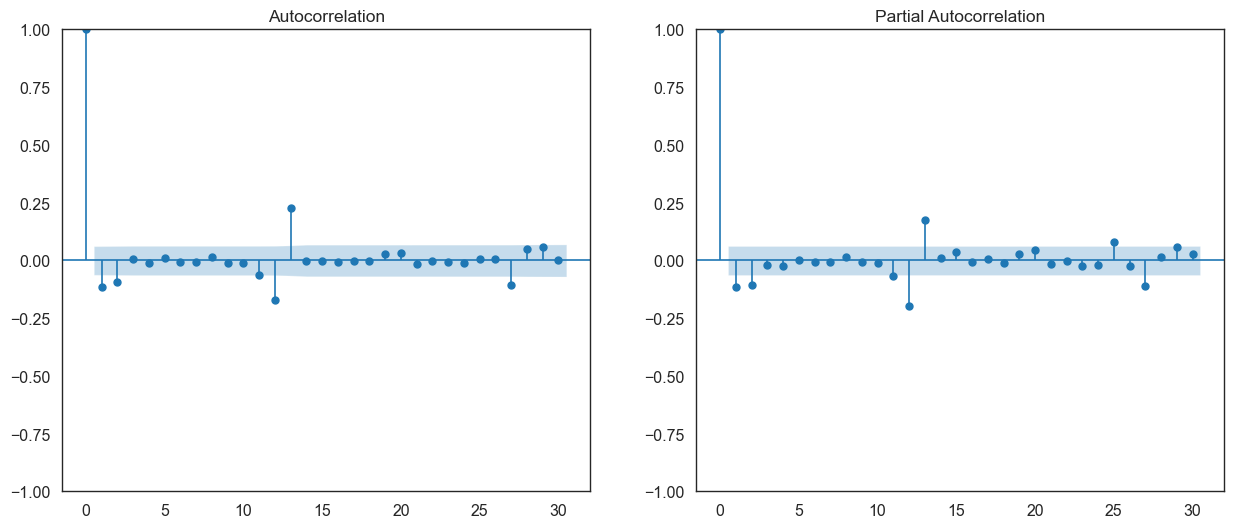

In [51]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(1,2,figsize=(15,6))
diff_1 = (train-train.shift(-1))[:1000]
plot_acf(diff_1,ax=ax[0])
plot_pacf(diff_1,ax=ax[1])
plt.show()

In [52]:
from statsforecast.arima import auto_arima_f
a, b = 0, 1000
out = auto_arima_f(train[a:b].to_numpy(),seasonal=True, period=24)
print(out['arma']) 

(0, 2, 0, 0, 1, 1, 0)


In [53]:
import statsmodels as sm
fitaas = sm.tsa.arima.model.ARIMA(train[a:b], order = (0,2,1), seasonal_order=(0,0,0,24)).fit()
fitaas.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                
===============================================================================
Dep. Variable:     Global_active_power   No. Observations:                 1000
Model:                  ARIMA(0, 2, 1)   Log Likelihood                 498.491
Date:                 Fri, 16 Feb 2024   AIC                           -992.982
Time:                         18:48:07   BIC                           -983.171
Sample:                              0   HQIC                          -989.253
                                - 1000                                         
Covariance Type:                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.0000      1.383     -0.723      0.470      -3.711       1.711
sigma2         0.0214      0.030      0.725      0.469      -0.036       0.079
===================================================================================
Ljung-Box (L1) (Q):                  13.65   Jarque-Bera (JB):           1415147.02
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              53.56   Skew:                            -6.55
Prob(H) (two-sided):                  0.00   Kurtosis:                       187.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [54]:
c = 100
sarima_pred = fitaas.forecast(c)
print('rsme:', np.sqrt(mean_squared_error(sarima_pred,train[b:b+c]))) 

rsme: 0.3188157739796067


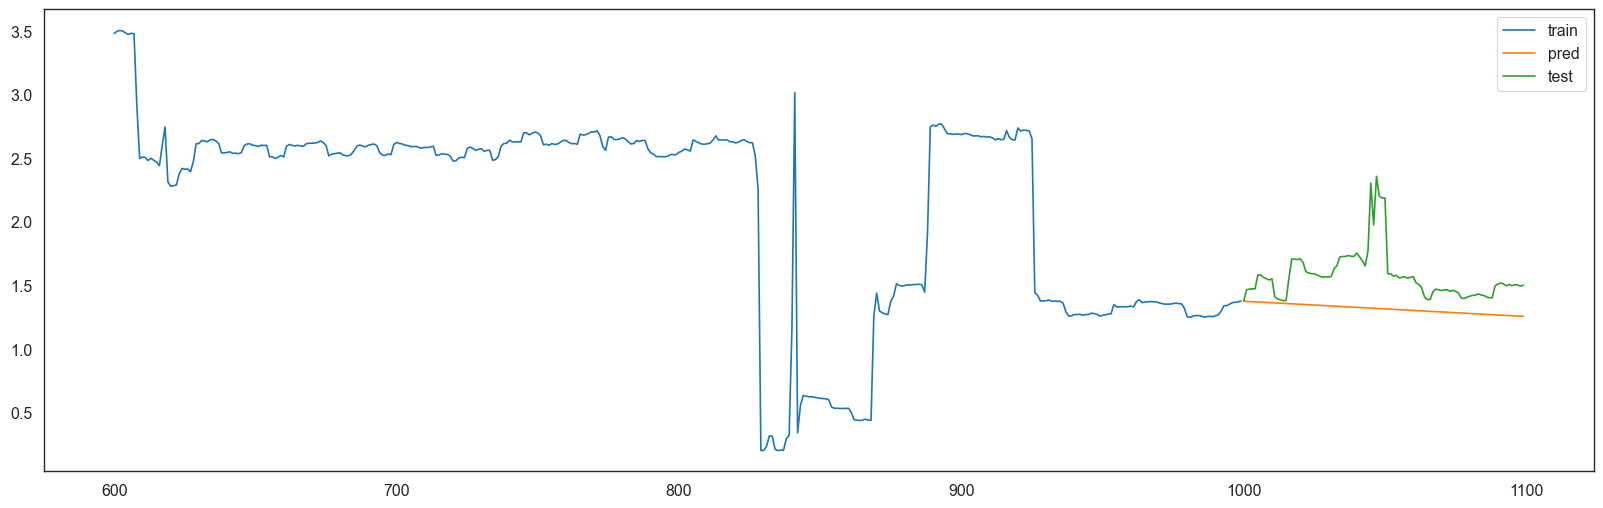

In [55]:
fig, ax = plt.subplots(1,1, figsize=(20,6))
ax.plot(train[b-400:b], label='train')
ax.plot(sarima_pred[:100], label='pred')
ax.plot(train[b:b+100], label='test')
ax.legend()
plt.show()

# ARIMAX

In [56]:
X_train = X_train.apply(pd.to_numeric, errors='coerce')

In [57]:
X_train_np = X_train.to_numpy()

In [58]:
out = auto_arima_f(X_train_np[0:1000,0],xreg = X_train_np[0:1000,1:], seasonal=True, period=24)
print(out['arma'])

(1, 1, 2, 0, 24, 0, 0)


In [59]:
fitaasx = sm.tsa.arima.model.ARIMA(X_train_np[0:1000,0], exog=X_train_np[0:1000,1:],order = (1,1,0),seasonal_order=(2,0,0,24)).fit()
fitaasx.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:                                y   No. Observations:                 1000
Model:             ARIMA(1, 1, 0)x(2, 0, 0, 24)   Log Likelihood                1967.621
Date:                          Fri, 16 Feb 2024   AIC                          -3907.242
Time:                                  18:50:02   BIC                          -3838.547
Sample:                                       0   HQIC                         -3881.132
                                         - 1000                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0028      0.002      1.316      0.188      -0.001       0.007
x2             0.0090      0.001      9.919      0.000       0.007       0.011
const       1.782e-17   3.25e-11   5.48e-07      1.000   -6.37e-11    6.37e-11
x3             0.0082      0.002      3.660      0.000       0.004       0.013
x4            -0.0040      0.002     -2.318      0.020      -0.007      -0.001
x5          1.085e-11   3.29e-11      0.330      0.741   -5.36e-11    7.53e-11
x6          1.085e-11   3.29e-11      0.330      0.741   -5.36e-11    7.53e-11
x7                  0   3.25e-11          0      1.000   -6.37e-11    6.37e-11
x8          1.085e-11   3.29e-11      0.330      0.741   -5.36e-11    7.53e-11
x9             0.0027      0.008      0.335      0.737      -0.013       0.018
ar.L1          0.1575      0.029      5.521      0.000       0.102       0.213
ar.S.L24      -0.1280      0.026     -4.877      0.000      -0.179      -0.077
ar.S.L48      -0.0862      0.037     -2.347      0.019      -0.158      -0.014
sigma2         0.0011   2.65e-05     42.972      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.30   Jarque-Bera (JB):              2143.27
Prob(Q):                              0.58   Prob(JB):                         0.00
Heteroskedasticity (H):               1.04   Skew:                            -0.03
Prob(H) (two-sided):                  0.69   Kurtosis:                        10.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.59e+28. Standard errors may be unstable.
"""

In [60]:
future_x =  X_train_np[1000:1200,1:]
fc = fitaasx.forecast(len(future_x),exog = future_x)

In [61]:
print('rsme:', np.sqrt(mean_squared_error(fc,X_train_np[1000:1200,0]))) 

rsme: 0.09082023653037823


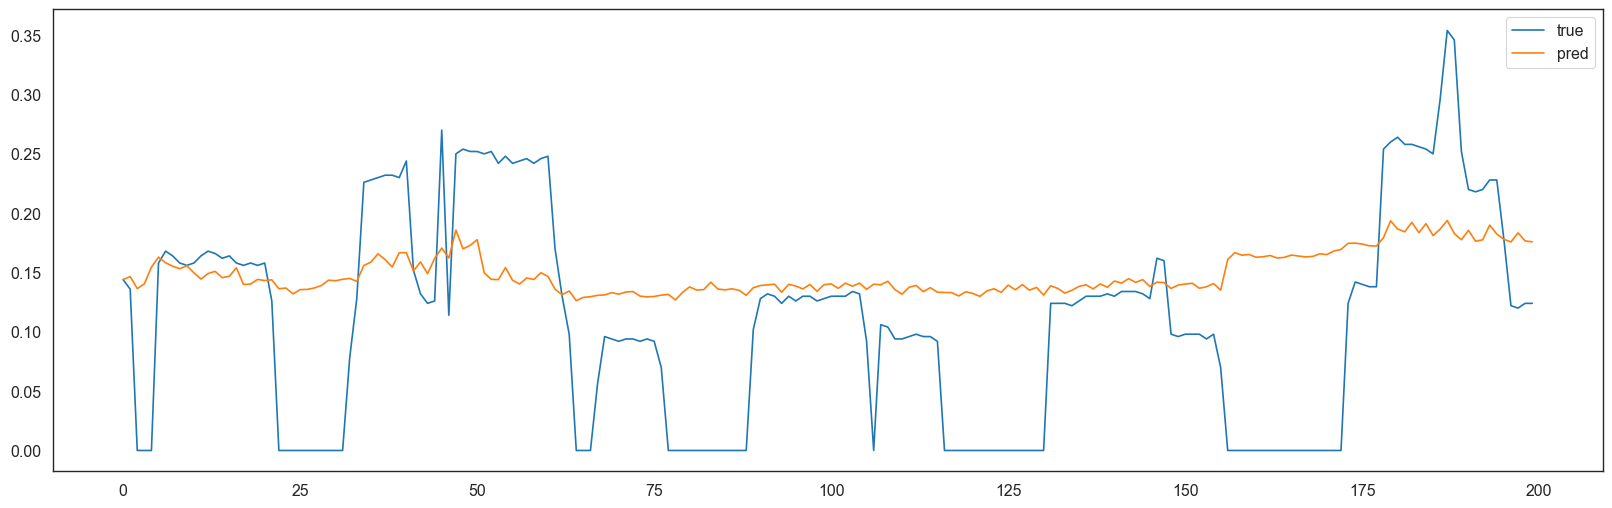

In [62]:
fig, ax = plt.subplots(1,1, figsize=(20,6))
ax.plot(X_train_np[1000:1200,0], label='true')
ax.plot(fc, label='pred')
ax.legend()
plt.show()

# SARIMAX

In [82]:
import pmdarima as pm

sxmodel = pm.auto_arima(X_train_np[0:1000,0],
                    exogenous=X_train_np[0:1000,1:],
                    start_p=0,
                    start_q=0,
                    max_p=3,
                    max_q=3, 
                    m=24,
                    start_P=0,
                    seasonal=True,
                    d=None,
                    D=None,
                    trace=True,
                    error_action='ignore',  
                    suppress_warnings=True, 
                    stepwise=True)

sxmodel.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,1)[24] intercept   : AIC=-1984.586, Time=0.68 sec
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=-1938.722, Time=0.04 sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=-3895.028, Time=0.74 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=-2948.628, Time=1.54 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=-1136.199, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[24] intercept   : AIC=-3879.869, Time=0.06 sec
 ARIMA(1,0,0)(2,0,0)[24] intercept   : AIC=-3904.216, Time=10.97 sec
 ARIMA(1,0,0)(2,0,1)[24] intercept   : AIC=-3901.147, Time=9.16 sec
 ARIMA(1,0,0)(1,0,1)[24] intercept   : AIC=-3902.186, Time=1.70 sec
 ARIMA(0,0,0)(2,0,0)[24] intercept   : AIC=-2004.756, Time=3.77 sec
 ARIMA(2,0,0)(2,0,0)[24] intercept   : AIC=-3946.159, Time=9.12 sec
 ARIMA(2,0,0)(1,0,0)[24] intercept   : AIC=-3941.184, Time=1.94 sec
 ARIMA(2,0,0)(2,0,1)[24] intercept   : AIC=-3943.381, Time=13.32 sec
 ARIMA(2,0,0)(1,0,1)[24] intercept   : AIC=-3943.924, Time=1.82 sec
 AR

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 1000
Model:             SARIMAX(1, 0, 1)x(2, 0, [], 24)   Log Likelihood                1979.340
Date:                             Sat, 17 Feb 2024   AIC                          -3946.680
Time:                                     21:22:32   BIC                          -3917.233
Sample:                                          0   HQIC                         -3935.488
                                            - 1000                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0135      0.003      4.696      0.000       0.008       0.019
ar.L1          0.8908      0.019     48.094      0.000       0.855       0.927
ma.L1          0.2294      0.035      6.593      0.000       0.161       0.298
ar.S.L24      -0.1206      0.027     -4.525      0.000      -0.173      -0.068
ar.S.L48      -0.0886      0.035     -2.536      0.011      -0.157      -0.020
sigma2         0.0011   2.85e-05     39.052      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              2148.40
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               0.97   Skew:                            -0.03
Prob(H) (two-sided):                  0.77   Kurtosis:                        10.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [78]:
sxmodel

ARIMA(order=(2, 0, 0), scoring_args={}, seasonal_order=(1, 0, 2, 12),
      suppress_warnings=True)

In [80]:
fitted, confint = sxmodel.predict(n_periods=200, return_conf_int=True, exogenous =  X_train_np[1000:1200,1:])

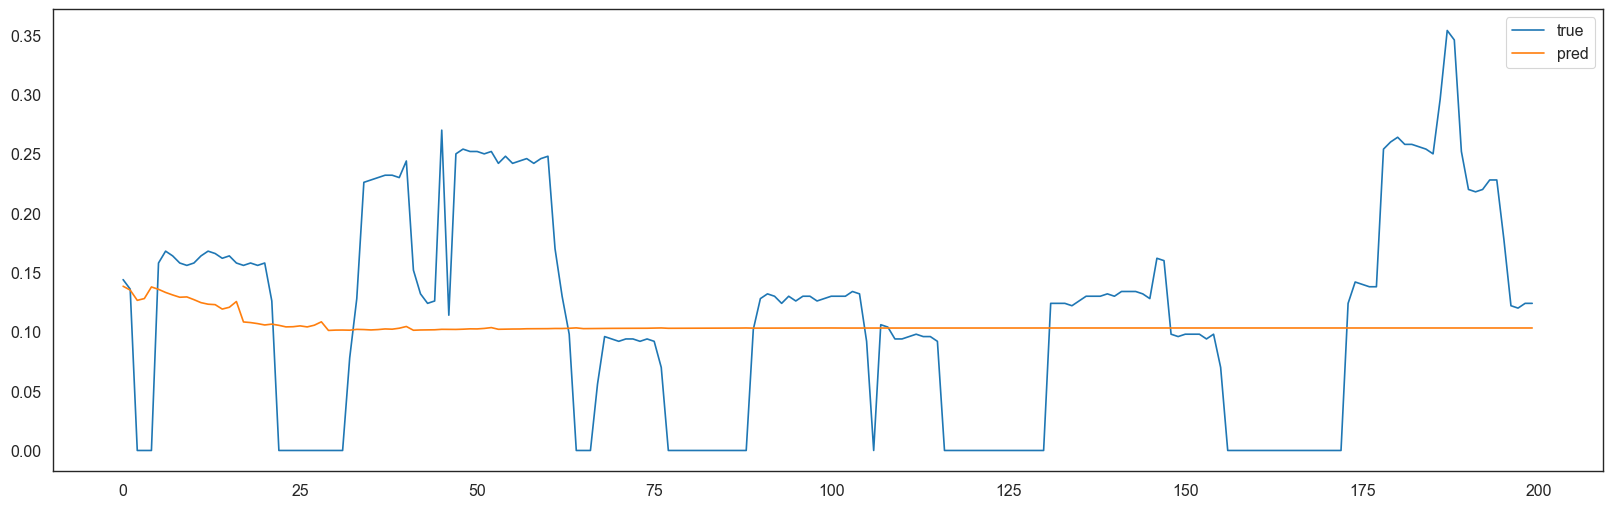

In [81]:
fig, ax = plt.subplots(1,1, figsize=(20,6))
ax.plot(X_train_np[1000:1200,0], label='true')
ax.plot(fitted, label='pred')
ax.legend()
plt.show()

# xgboost

In [ ]:
# train-test split
# from sklearn.model_selection import train_test_split
# multivariante
df.dropna(inplace=True)
X_cols = ['month', 'week', 'dayofweek', 'day', 'hour']
X_train, y_train, X_test, y_test = df.iloc[:195480,:][X_cols], df.iloc[:195480,:]['Global_active_power'],df.iloc[195480:,:][X_cols], df.iloc[195480:,:]['Global_active_power']

In [ ]:
from xgboost import XGBRegressor
import xgboost

xgb = XGBRegressor()
xgb.fit(X_train, y_train)
pred = xgb.predict(X_test)
print('rsme:', np.sqrt(mean_squared_error(pred,y_test))) 

rsme: 1.0763004608488782


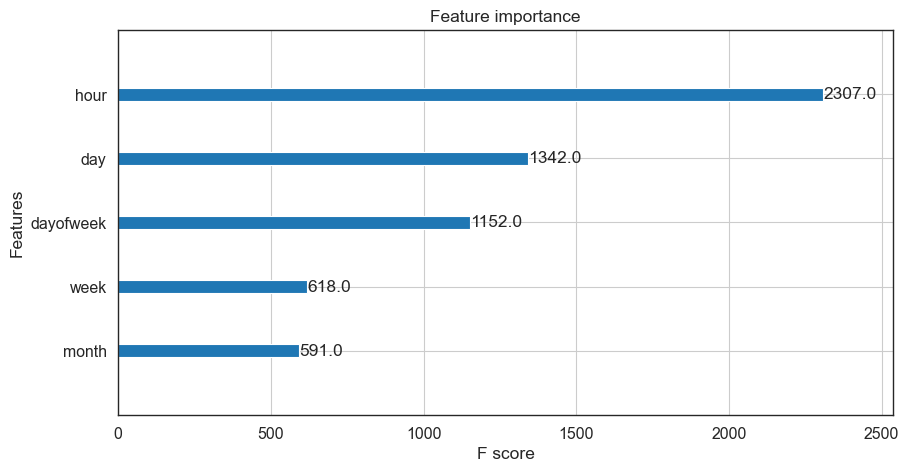

In [ ]:
import xgboost
plt.rcParams["figure.figsize"] = (10, 5)
xgboost.plot_importance(xgb, importance_type='weight')
plt.show()

# LSTM

In [94]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.functional as F
import plotly.graph_objects as go

from tqdm.notebook import tqdm
from torchsummary import summary
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader

In [129]:
df = df[['Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3', 'month', 'week', 'dayofweek', 'day', 'hour', 'Global_active_power']]

In [172]:
# normalize data
cols = ['Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3', 'month', 'week', 'dayofweek', 'day', 'hour', 'Global_active_power']
sc = MinMaxScaler()
label_sc = MinMaxScaler()
df[cols] = sc.fit_transform(df[cols].values)

# Obtaining the scaler for the labels(usage data) so that output can be
# re-scaled to actual value during evaluation
df['Global_active_power'] = label_sc.fit_transform(df['Global_active_power'].values.reshape(-1, 1))

In [173]:
df.shape

(256869, 12)

In [174]:
data = df.values

In [175]:
seq_len=11
sequences=[]
for index in range(len(data) - seq_len + 1): 
    sequences.append(data[index: index + seq_len])
sequences= np.array(sequences)

In [176]:
sequences.shape

(256859, 11, 12)

In [177]:
valid_set_size_percentage = 10 
test_set_size_percentage = 10 

valid_set_size = int(np.round(valid_set_size_percentage/100*sequences.shape[0]))  
test_set_size  = int(np.round(test_set_size_percentage/100*sequences.shape[0]))
train_set_size = sequences.shape[0] - (valid_set_size + test_set_size)

x_train = sequences[:train_set_size,:-1,:]
y_train = sequences[:train_set_size,-1,:]
    
x_valid = sequences[train_set_size:train_set_size+valid_set_size,:-1,:]
y_valid = sequences[train_set_size:train_set_size+valid_set_size,-1,:]
    
x_test = sequences[train_set_size+valid_set_size:,:-1,:]
y_test = sequences[train_set_size+valid_set_size:,-1,:]

In [178]:
x_train.shape

(205487, 10, 12)

In [179]:
x_train = torch.tensor(x_train).float()
y_train = torch.tensor(y_train).float()

x_valid = torch.tensor(x_test).float()
y_valid = torch.tensor(y_test).float()

train_dataset = TensorDataset(x_train,y_train)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)

valid_dataset = TensorDataset(x_valid,y_valid)
valid_dataloader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

In [180]:
from torch import nn
class NeuralNetwork(nn.Module):
    def __init__(self, num_feature):
        super(NeuralNetwork, self).__init__()
        self.lstm  = nn.LSTM(num_feature,64,batch_first=True)
        self.fc    = nn.Linear(64,num_feature)
        
    def forward(self, x):
        output, (hidden, cell) = self.lstm(x)
        x = self.fc(hidden)
        return x

model = NeuralNetwork(12)

#push to cuda if available
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
# model = model.to(device)

In [181]:
# print summary of model like summary in tensorflow
summary(model, (12, ))

Layer (type:depth-idx)                   Output Shape              Param #
├─LSTM: 1-1                              [-1, 64]                  19,968
├─Linear: 1-2                            [-1, 12]                  780
Total params: 20,748
Trainable params: 20,748
Non-trainable params: 0
Total mult-adds (M): 0.02
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.08
Estimated Total Size (MB): 0.08


Layer (type:depth-idx)                   Output Shape              Param #
├─LSTM: 1-1                              [-1, 64]                  19,968
├─Linear: 1-2                            [-1, 12]                  780
Total params: 20,748
Trainable params: 20,748
Non-trainable params: 0
Total mult-adds (M): 0.02
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.08
Estimated Total Size (MB): 0.08

In [182]:
optimizer = optim.Adam(model.parameters())
mse = nn.MSELoss()

In [183]:
def train(dataloader):
    epoch_loss = 0
    model.train()  
    
    for batch in dataloader:
        optimizer.zero_grad()          
        x,y= batch
        pred = model(x)
        loss = mse(pred[0],y)        
        loss.backward()               
        optimizer.step()      
        epoch_loss += loss.item()  
        
    return epoch_loss

In [184]:
def evaluate(dataloader):
    epoch_loss = 0
    model.eval()  
    
    with torch.no_grad():
      for batch in dataloader:   
          x,y= batch
          pred = model(x)
          loss = mse(pred[0],y)              
          epoch_loss += loss.item()  
        
    return epoch_loss / len(dataloader)

In [185]:
train(train_dataloader)

25.355773982439132

In [186]:
n_epochs = 50
best_valid_loss = float('inf')

for epoch in range(1, n_epochs + 1):

    train_loss = train(train_dataloader)
    valid_loss = evaluate(valid_dataloader)
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model, 'saved_weights.pt')

    print("Epoch ",epoch+1)
    print(f'\tTrain Loss: {train_loss:.5f} | ' + f'\tVal Loss: {valid_loss:.5f}\n')

Epoch  2
	Train Loss: 8.27651 | 	Val Loss: 0.00724

Epoch  3
	Train Loss: 6.83362 | 	Val Loss: 0.00552

Epoch  4
	Train Loss: 6.22912 | 	Val Loss: 0.00493

Epoch  5
	Train Loss: 5.83689 | 	Val Loss: 0.00420

Epoch  6
	Train Loss: 5.54157 | 	Val Loss: 0.00364

Epoch  7
	Train Loss: 5.31739 | 	Val Loss: 0.00324

Epoch  8
	Train Loss: 5.16023 | 	Val Loss: 0.00308

Epoch  9
	Train Loss: 5.03712 | 	Val Loss: 0.00282

Epoch  10
	Train Loss: 4.95396 | 	Val Loss: 0.00270

Epoch  11
	Train Loss: 4.87791 | 	Val Loss: 0.00263

Epoch  12
	Train Loss: 4.77660 | 	Val Loss: 0.00252

Epoch  13
	Train Loss: 4.67955 | 	Val Loss: 0.00241

Epoch  14
	Train Loss: 4.58938 | 	Val Loss: 0.00228

Epoch  15
	Train Loss: 4.51628 | 	Val Loss: 0.00226

Epoch  16
	Train Loss: 4.46162 | 	Val Loss: 0.00220

Epoch  17
	Train Loss: 4.40466 | 	Val Loss: 0.00220

Epoch  18
	Train Loss: 4.35227 | 	Val Loss: 0.00208

Epoch  19
	Train Loss: 4.30694 | 	Val Loss: 0.00205

Epoch  20
	Train Loss: 4.26905 | 	Val Loss: 0.00205

E

In [187]:
model=torch.load('saved_weights.pt')

In [188]:
x_test= torch.tensor(x_test).float()

with torch.no_grad():
  y_test_pred = model(x_test)

y_test_pred = y_test_pred.numpy()[0]

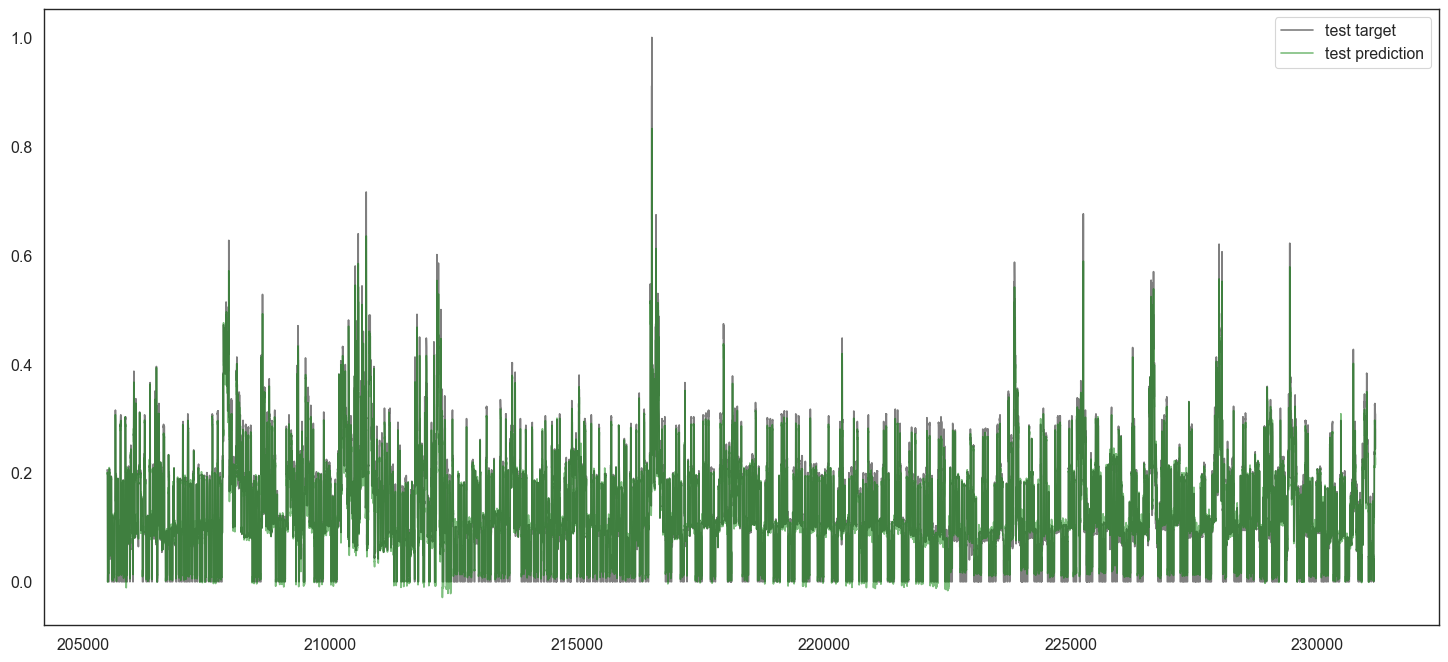

In [190]:
idx=0
plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_test.shape[0]),
         y_test[:,idx], alpha=0.5, color='black', label='test target')

plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_test_pred.shape[0]),
         y_test_pred[:,idx], alpha=0.5, color='green', label='test prediction')

plt.legend(loc='best')

In [191]:
index_values = df[len(df) - len(y_test):].index
col_values = cols
df_results = pd.DataFrame(data=y_test_pred, index=index_values, columns=col_values)
df_results

,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,month,week,dayofweek,day,hour,Global_active_power
datetime,,,,,,,,,,,,
2007-06-13 03:51:00,0.2008,0.6267,0.0228,-0.0046,0.0021,-0.0187,0.9550,0.8773,0.3486,0.4240,0.1447,0.0219
2007-06-13 03:52:00,0.1995,0.6123,0.0232,-0.0044,0.0019,-0.0180,0.9561,0.8784,0.3492,0.4247,0.1436,0.0222
2007-06-13 03:53:00,0.1997,0.6086,0.0230,-0.0042,0.0019,-0.0181,0.9555,0.8778,0.3490,0.4246,0.1439,0.0220
2007-06-13 03:54:00,0.1978,0.6052,0.0231,-0.0041,0.0018,-0.0186,0.9555,0.8779,0.3489,0.4245,0.1436,0.0220
2007-06-13 03:55:00,0.1997,0.6048,0.0232,-0.0040,0.0018,-0.0183,0.9553,0.8777,0.3487,0.4245,0.1438,0.0221
...,...,...,...,...,...,...,...,...,...,...,...,...
2007-06-30 23:55:00,0.2813,0.5000,0.2571,0.0323,-0.0014,0.8736,0.8840,0.8721,0.8004,0.8475,0.9475,0.2610
2007-06-30 23:56:00,0.2811,0.5068,0.2582,0.0397,0.0020,0.8780,0.8813,0.8702,0.8011,0.8512,0.9435,0.2615
2007-06-30 23:57:00,0.2803,0.5000,0.2655,0.0437,0.0048,0.8625,0.8828,0.8710,0.8006,0.8489,0.9472,0.2691


In [205]:
# Get the last sequence of historical data as features for predicting the next 10 days
last_sequence = sequences[-1:, 1:, :]
last_sequence = torch.from_numpy(last_sequence).float()

# Generate predictions for the next 10 days
PRED_DAYS = 10
with torch.no_grad():
    for i in range(PRED_DAYS):
        pred_i = model(last_sequence)
        last_sequence = torch.cat((last_sequence, pred_i), dim=1)
        last_sequence = last_sequence[:, 1:, :]


pred_days = last_sequence.reshape(PRED_DAYS, 12).numpy()

# inverse transform the predicted values
# pred_days[:, :-1] = sc.inverse_transform(pred_days[:, :-1])
pred_days[:, -1] = label_sc.inverse_transform(pred_days[:, -1].reshape(-1,1))[:,0]

df_pred = pd.DataFrame(
    data=pred_days,
    columns=cols
)

df_pred

,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,month,week,dayofweek,day,hour,Global_active_power
0,0.2793,0.5117,0.2380,0.0350,0.0179,0.8572,0.8785,0.8681,0.7993,0.8509,0.9436,0.2410
1,0.2667,0.4618,0.2646,0.0974,0.0361,0.8382,0.8570,0.8447,0.8076,0.8225,0.9458,0.2672
2,0.2572,0.4069,0.3021,0.1872,0.0647,0.8266,0.8487,0.8316,0.8174,0.7856,0.9420,0.3057
3,0.2500,0.3426,0.3517,0.2916,0.1000,0.8082,0.8537,0.8294,0.8317,0.7492,0.9379,0.3553
4,0.2447,0.2676,0.4150,0.4085,0.1386,0.7872,0.8652,0.8330,0.8522,0.7171,0.9343,0.4171
5,0.2419,0.1799,0.4969,0.5473,0.1805,0.7636,0.8791,0.8388,0.8776,0.6878,0.9326,0.4963
6,0.2419,0.0833,0.5926,0.7027,0.2230,0.7359,0.8923,0.8443,0.9049,0.6609,0.9338,0.5883
7,0.2444,-0.0076,0.6843,0.8546,0.2543,0.7031,0.8993,0.8456,0.9289,0.6354,0.9374,0.6755
8,0.2481,-0.0773,0.7599,0.9995,0.2656,0.6682,0.8999,0.8421,0.9428,0.6061,0.9479,0.7456
9,0.2547,-0.1205,0.8197,1.1380,0.2638,0.6403,0.9053,0.8416,0.9430,0.5658,0.9767,0.7986


In [208]:
label_sc.inverse_transform(pred_days[:, -1].reshape(-1,1))

array([[0.24095482],
       [0.2672466 ],
       [0.30567586],
       [0.3553279 ],
       [0.4171127 ],
       [0.49634856],
       [0.5883468 ],
       [0.67554885],
       [0.7456388 ],
       [0.79855424]], dtype=float32)

In [195]:
pred_days.shape

(10, 12)

# LSTM

In [ ]:
label_col_index = 0  # consumption as label to predict
inputs_cols_indices = range(
    5
)  # use (consumption, hour, dayofweek, month, dayofyear) columns as features

# Define window_size period and split inputs/labels
window_size = 90

# The scaler objects will be stored in this dictionary so that our output test data from the model can be re-scaled during evaluation
label_scalers = {}

train_x = []
test_x = {}
test_y = {}

# Skipping the files we're not using
processing_files = [
    file for file in os.listdir(data_dir) if os.path.splitext(file)[1] == ".csv"
]

num_files_for_dataset = 5

for file in tqdm_notebook(processing_files[:num_files_for_dataset]):
    print(f"Processing {file} ...")
    # Store csv file in a Pandas DataFrame
    df = pd.read_csv(os.path.join(data_dir, file), parse_dates=["Datetime"])

    # Processing the time data into suitable input formats
    df["hour"] = df.apply(lambda x: x["Datetime"].hour, axis=1)
    df["dayofweek"] = df.apply(lambda x: x["Datetime"].dayofweek, axis=1)
    df["month"] = df.apply(lambda x: x["Datetime"].month, axis=1)
    df["dayofyear"] = df.apply(lambda x: x["Datetime"].dayofyear, axis=1)
    df = df.sort_values("Datetime").drop("Datetime", axis=1)

    # Scaling the input data
    sc = MinMaxScaler()
    label_sc = MinMaxScaler()
    data = sc.fit_transform(df.values)

    # Obtaining the scaler for the labels(usage data) so that output can be
    # re-scaled to actual value during evaluation
    label_sc.fit(df.iloc[:, label_col_index].values.reshape(-1, 1))
    label_scalers[file] = label_sc

    # Move the window
    inputs, labels = move_sliding_window(
        data,
        window_size,
        inputs_cols_indices=inputs_cols_indices,
        label_col_index=label_col_index,
    )

    # CONCAT created instances from all .csv files.
    # Split data into train/test portions and combining all data from different files into a single array
    test_portion = int(0.1 * len(inputs))
    if len(train_x) == 0:  # first iteration
        train_x = inputs[:-test_portion]
        train_y = labels[:-test_portion]
    else:
        train_x = np.concatenate((train_x, inputs[:-test_portion]))
        train_y = np.concatenate((train_y, labels[:-test_portion]))
    test_x[file] = inputs[-test_portion:]
    test_y[file] = labels[-test_portion:]

In [ ]:
class LSTMNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.2):
        super(LSTMNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        self.lstm = nn.LSTM(
            input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob
        )
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x, h):
        out, h = self.lstm(x, h)
        out = self.fc(self.relu(out[:, -1]))
        return out, h

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        # Initialze h_0, c_0 with zeros
        hidden = (
            weight.new(self.n_layers, batch_size, self.hidden_dim)
            .zero_()
            .to(device),  # h_0
            weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
        )
        return hidden

# prophet

In [65]:
from fbprophet import Prophet
from fbprophet.plot import plot_plotly
import plotly.offline as py
py.init_notebook_mode()

ModuleNotFoundError: No module named 'fbprophet'